# ML on ESDC using PyTorch 
A DeepESDL example notebook

## Linear Regression for prediction of missing land surface temperature values from air temperature values
This notebook demonstrates how to implement Machine Learning on the Earth System Data Cube using the ML library PyTorch. The workflow is self-contained and based on a generic use case to showcase data loading, sampling strategies, model training, model evaluation and visualisation.

Please, also refer to the DeepESDL documentation and visit the platform's website for further information!

ScaDS.AI, 2023

**This notebook runs needs a python conda environment with pytorch and mlflow installed, please checkout the documentation for help on [changing the environment](https://deepesdl.readthedocs.io/en/v2022.12.1/guide/jupyterlab/). You can follow the MLFlow Experiment run via the bundled MLFlow UI.**

### Import necessary libraries

In [1]:
import torch
import mlflow
import numpy as np
import pandas as pd
import dask.array as da
from torch import nn
from global_land_mask import globe
from torch.utils.data import TensorDataset
from xcube.core.store import new_data_store
from matplotlib.colors import LinearSegmentedColormap

import logging
logging.getLogger("mlflow.utils.requirements_utils").setLevel(logging.ERROR)

### Load Data (Earth System Data Cube)
We load the ESDC (*.zarr) from the s3 data store (lazy load). The ESDC consists of three dimensions (longitude, latitude, time). Out of many available cube variables, which are dask arrays, we load two ("land_surface_temperature", "air_temperature_2m"). 

In [2]:
data_store = new_data_store("s3", root="esdl-esdc-v2.1.1", storage_options=dict(anon=True))
dataset    = data_store.open_data("esdc-8d-0.083deg-184x270x270-2.1.1.zarr")

# Smaller cube for demo case
start_time = "2002-05-21"
end_time   = "2002-08-01"
ds         = dataset[["land_surface_temperature", "air_temperature_2m"]].sel(time=slice(start_time, end_time))
ds

<xarray.Dataset>
Dimensions:                   (time: 10, lat: 2160, lon: 4320)
Coordinates:
  * lat                       (lat) float64 89.96 89.88 89.79 ... -89.87 -89.96
  * lon                       (lon) float64 -180.0 -179.9 -179.8 ... 179.9 180.0
  * time                      (time) datetime64[ns] 2002-05-21 ... 2002-08-01
Data variables:
    land_surface_temperature  (time, lat, lon) float32 dask.array<chunksize=(10, 270, 270), meta=np.ndarray>
    air_temperature_2m        (time, lat, lon) float32 dask.array<chunksize=(10, 270, 270), meta=np.ndarray>
Attributes: (12/35)
    Metadata_conventions :     Unidata Dataset Discovery v1.0
    acknowledgment:            The ESDL team acknowledges all data providers! 
    chunking:                  1x2160x4320
    comment:                   none. 
    contributor_name:          Max Planck Institute for Biogeochemistry
    contributor_role:          ESDL Science Lead 
    ...                        ...
    summary:                   This data set contains a data cube of Earth Sy...
    time_coverage_duration:    P40Y
    time_coverage_end:         31.12.2018
    time_coverage_resolution:  P8D
    time_coverage_start:       05.01.1979
    title:                     Earth System Data Cube

### Add land mask variable 
Here we exclude redundant water surface values for our use case and only consider solid Earth data for our ML analysis. We extend the ESDC by a new variable "land_mask". The mask is a data array initialized for one time slice of the ESDC. 

In [3]:
lon_grid, lat_grid = np.meshgrid(ds.lon,ds.lat)
lm0                = da.from_array(globe.is_land(lat_grid, lon_grid))
lm0

dask.array<array, shape=(2160, 4320), dtype=bool, chunksize=(2160, 4320), chunktype=numpy.ndarray>

We now extend the mask to all time slices of the ESDC.

In [4]:
lm = da.stack([lm0 for i in range(ds.sizes["time"])], axis = 0)
lm

dask.array<stack, shape=(10, 2160, 4320), dtype=bool, chunksize=(1, 2160, 4320), chunktype=numpy.ndarray>

We add the mask as variable to the ESDC. The cube now consists of three equally chunked variables ("land_surface_temperature", "air_temperature_2m", "land_mask"). 

In [5]:
from ml4xcube.cube_utilities import get_chunk_sizes

xdsm = ds.assign(
    land_mask = (
        ["time","lat","lon"],
        lm.rechunk(
            chunks=([v for k,v in get_chunk_sizes(ds)])
        )
    )
)
xdsm

<xarray.Dataset>
Dimensions:                   (time: 10, lat: 2160, lon: 4320)
Coordinates:
  * lat                       (lat) float64 89.96 89.88 89.79 ... -89.87 -89.96
  * lon                       (lon) float64 -180.0 -179.9 -179.8 ... 179.9 180.0
  * time                      (time) datetime64[ns] 2002-05-21 ... 2002-08-01
Data variables:
    land_surface_temperature  (time, lat, lon) float32 dask.array<chunksize=(10, 270, 270), meta=np.ndarray>
    air_temperature_2m        (time, lat, lon) float32 dask.array<chunksize=(10, 270, 270), meta=np.ndarray>
    land_mask                 (time, lat, lon) bool dask.array<chunksize=(10, 270, 270), meta=np.ndarray>
Attributes: (12/35)
    Metadata_conventions :     Unidata Dataset Discovery v1.0
    acknowledgment:            The ESDL team acknowledges all data providers! 
    chunking:                  1x2160x4320
    comment:                   none. 
    contributor_name:          Max Planck Institute for Biogeochemistry
    contributor_role:          ESDL Science Lead 
    ...                        ...
    summary:                   This data set contains a data cube of Earth Sy...
    time_coverage_duration:    P40Y
    time_coverage_end:         31.12.2018
    time_coverage_resolution:  P8D
    time_coverage_start:       05.01.1979
    title:                     Earth System Data Cube

### Plot masked data for one time slice

In [6]:
ds_slice = xdsm.sel({"time" : "2002-05-21"})
ds_slice

<xarray.Dataset>
Dimensions:                   (lat: 2160, lon: 4320)
Coordinates:
  * lat                       (lat) float64 89.96 89.88 89.79 ... -89.87 -89.96
  * lon                       (lon) float64 -180.0 -179.9 -179.8 ... 179.9 180.0
    time                      datetime64[ns] 2002-05-21
Data variables:
    land_surface_temperature  (lat, lon) float32 dask.array<chunksize=(270, 270), meta=np.ndarray>
    air_temperature_2m        (lat, lon) float32 dask.array<chunksize=(270, 270), meta=np.ndarray>
    land_mask                 (lat, lon) bool dask.array<chunksize=(270, 270), meta=np.ndarray>
Attributes: (12/35)
    Metadata_conventions :     Unidata Dataset Discovery v1.0
    acknowledgment:            The ESDL team acknowledges all data providers! 
    chunking:                  1x2160x4320
    comment:                   none. 
    contributor_name:          Max Planck Institute for Biogeochemistry
    contributor_role:          ESDL Science Lead 
    ...                        ...
    summary:                   This data set contains a data cube of Earth Sy...
    time_coverage_duration:    P40Y
    time_coverage_end:         31.12.2018
    time_coverage_resolution:  P8D
    time_coverage_start:       05.01.1979
    title:                     Earth System Data Cube

Air Temperature

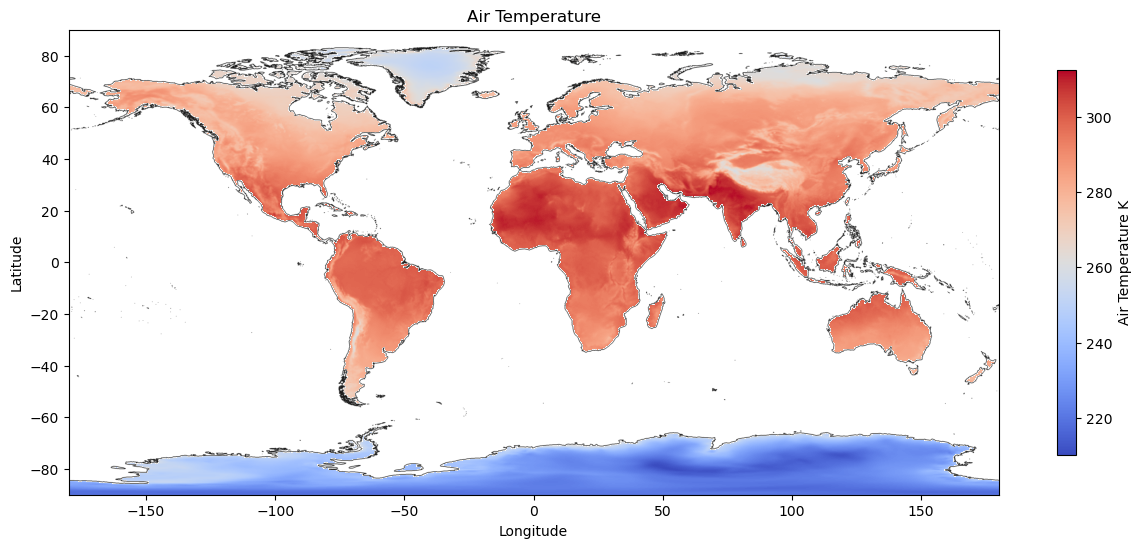

In [7]:
from ml4xcube.xr_plots import plot_slice

plot_slice(
    ds          = ds_slice,
    var_to_plot = "air_temperature_2m",
    xdim        = "lon",
    ydim        = "lat",
    color_map   = "coolwarm",
    title       = "Air Temperature",
    label       = "Air Temperature K"
)

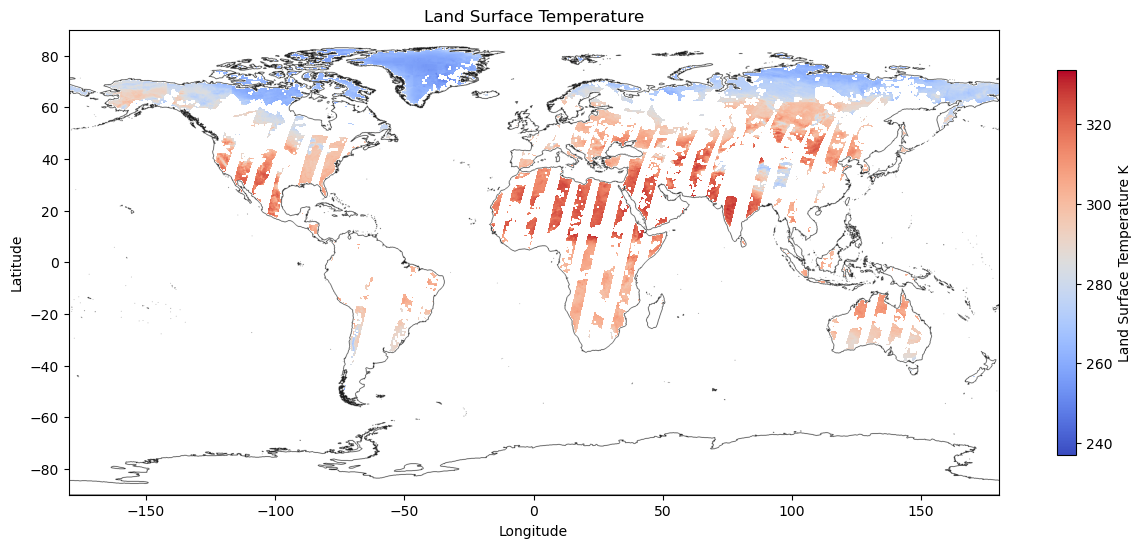

In [8]:
from ml4xcube.xr_plots import plot_slice

plot_slice(
    ds          = ds_slice,
    var_to_plot = "land_surface_temperature",
    xdim        = "lon",
    ydim        = "lat",
    color_map   = "coolwarm",
    title       = "Land Surface Temperature",
    label       = "Land Surface Temperature K"
)

Land Surface Temperature

### Train/Test Split assignment
Here you can choose between random sampling and block sampling. Based on the use case, the application of ML analyses on remotely sensed data is prone to autocorrelation, especially when the data is split randomly. Block sampling is one strategy to deal with autocorrelation.

In [9]:
from ml4xcube.data_split import assign_rand_split, assign_block_split

# random sampling
#xds = assign_rand_split(
#    ds    = xdsm,
#    split = 0.8
#)

# block sampling
xds = assign_block_split(
    ds         = xdsm,
    block_size = [("time", 10), ("lat", 100), ("lon", 100)],
    split      = 0.8
)
xds

<xarray.Dataset>
Dimensions:                   (time: 10, lat: 2160, lon: 4320)
Coordinates:
  * lat                       (lat) float64 89.96 89.88 89.79 ... -89.87 -89.96
  * lon                       (lon) float64 -180.0 -179.9 -179.8 ... 179.9 180.0
  * time                      (time) datetime64[ns] 2002-05-21 ... 2002-08-01
Data variables:
    land_surface_temperature  (time, lat, lon) float32 dask.array<chunksize=(10, 270, 270), meta=np.ndarray>
    air_temperature_2m        (time, lat, lon) float32 dask.array<chunksize=(10, 270, 270), meta=np.ndarray>
    land_mask                 (time, lat, lon) bool dask.array<chunksize=(10, 270, 270), meta=np.ndarray>
    split                     (time, lat, lon) float64 dask.array<chunksize=(10, 100, 100), meta=np.ndarray>
Attributes: (12/35)
    Metadata_conventions :     Unidata Dataset Discovery v1.0
    acknowledgment:            The ESDL team acknowledges all data providers! 
    chunking:                  1x2160x4320
    comment:                   none. 
    contributor_name:          Max Planck Institute for Biogeochemistry
    contributor_role:          ESDL Science Lead 
    ...                        ...
    summary:                   This data set contains a data cube of Earth Sy...
    time_coverage_duration:    P40Y
    time_coverage_end:         31.12.2018
    time_coverage_resolution:  P8D
    time_coverage_start:       05.01.1979
    title:                     Earth System Data Cube

Plot train/test assignment

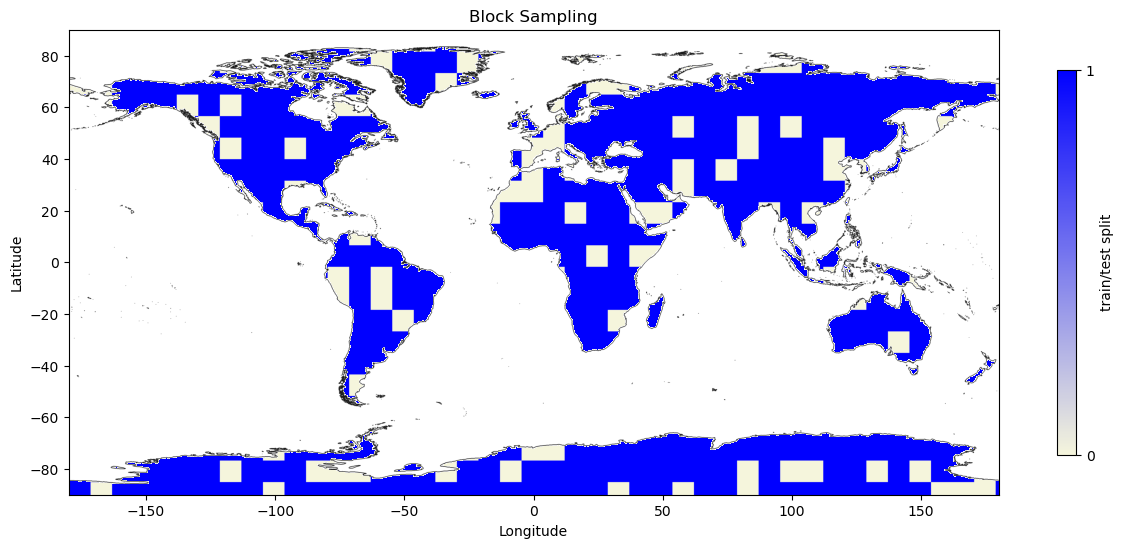

In [10]:
from ml4xcube.xr_plots import plot_slice

ds_slice = xds.sel({"time" : "2002-05-21"})
ds_slice = ds_slice.rename({"split": "plot_split"})

color_map = LinearSegmentedColormap.from_list("", ["beige","blue"])

plot_slice(
    ds          = ds_slice,
    var_to_plot = "plot_split",
    xdim        = "lon",
    ydim        = "lat",
    color_map   = color_map,
    title       = "Block Sampling",
    label       = "train/test split",
    ticks       = [0,1]
)

### Select cuda device if available to use GPU ressources

In [11]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


### Initialize MLFlow experiment

In [12]:
experiment_name = "Pytorch Linear Regression of LST from AT with mlflow"
mlflow.set_experiment(experiment_name)

current_experiment = dict(mlflow.get_experiment_by_name(experiment_name))
experiment_id      = current_experiment["experiment_id"]

run_name = "ESDC_LR_block_0.1"
mlflow.autolog()

### Train-/ and Test Set Creation and Preprocessing

We iterate through the chunks of the ESDC. The data will be preprocessed by flattening, choosing values, removing NaNs, normalization or standardization. Further, we will split the data into a training and testing fraction. We generate a train data loader and a test data loader and perform a linear regression. The train and test errors are returned during model training.

In [13]:
from ml4xcube.datasets.xr_dataset import XrDataset

dataset = XrDataset(ds=xds, num_chunks=5, rand_chunk=False).get_dataset()

{'land_surface_temperature': array([262.01  , 261.918 , 261.52  , ..., 284.8112, 281.5765, 277.8594],
      dtype=float32), 'air_temperature_2m': array([267.48087, 267.48087, 267.48087, ..., 275.19656, 275.19656,
       275.19656], dtype=float32), 'land_mask': array([False, False, False, ...,  True,  True,  True]), 'split': array([0., 0., 0., ..., 1., 1., 1.])}


Get range (min, max) and statistics (mean, std) of data variables for normalization or standardization.

In [14]:
from ml4xcube.preprocessing import get_range, get_statistics

#at_range  = get_range(ds, "air_temperature_2m")
#lst_range = get_range(ds, "land_surface_temperature")

at_stat  = get_statistics(dataset, "air_temperature_2m")
lst_stat = get_statistics(dataset, "land_surface_temperature")

Standardize/normalize data

In [15]:
from ml4xcube.preprocessing import normalize, standardize

#X = normalize(dataset['air_temperature_2m'], *at_range)
#y = normalize(dataset['land_surface_temperature'], *lst_range)

X = standardize(dataset["air_temperature_2m"], *at_stat)
y = standardize(dataset["land_surface_temperature"], *lst_stat)

Split the data into train/test set

In [16]:
X_train, X_test = X[dataset["split"] == True], X[dataset["split"] == False]
y_train, y_test = y[dataset["split"] == True], y[dataset["split"] == False]

X_train = X_train.reshape(-1, 1)  # Making it [num_samples, 1]
y_train = y_train.reshape(-1, 1)  
X_test  = X_test.reshape(-1, 1)
y_test  = y_test.reshape(-1, 1)

#### Prepare Datasets before Training

In [17]:
from ml4xcube.datasets.pytorch import prepare_dataloader

train_ds     = TensorDataset(torch.tensor(X_train), torch.tensor(y_train))
train_loader = prepare_dataloader(train_ds, batch_size=128, num_workers=5, parallel=False)
                
test_ds      = TensorDataset(torch.tensor(X_test), torch.tensor(y_test))
test_loader  = prepare_dataloader(test_ds, batch_size=128, num_workers=5, parallel=False)


### Define Model, Loss and Optimizer

In [18]:
lr     = 0.01
epochs = 20

#reg_model = nn.Linear(in_features=1, out_features=1, bias=True)
reg_model = torch.nn.Sequential(
    torch.nn.Linear(in_features=1, out_features=3, bias=True),
    torch.nn.ReLU(),
    torch.nn.Linear(in_features=3, out_features=3, bias=True),
    torch.nn.ReLU(),
    torch.nn.Linear(in_features=3, out_features=3, bias=True),
    torch.nn.ReLU(),
    torch.nn.Linear(in_features=3, out_features=1, bias=True) 
)

mse_loss  = torch.nn.MSELoss(reduction="mean")
optimizer = torch.optim.Adam(reg_model.parameters(), lr=lr)

### Train model

In [19]:
from ml4xcube.training.pytorch import Trainer

# Define the path for saving the best model and snapshots
best_model_path = "./best_model.pth"

with mlflow.start_run(experiment_id=experiment_id, run_name = run_name) as run:
    
    mlflow.log_param('lr', lr)
    mlflow.log_param('number_epochs', epochs)

    # Trainer instance
    trainer = Trainer(
        model            = reg_model,
        train_data       = train_loader,
        test_data        = test_loader,
        optimizer        = optimizer,
        best_model_path  = best_model_path,
        early_stopping   = True,
        patience         = 3,
        loss             = mse_loss,
        mlflow_run       = mlflow,
        epochs           = epochs,
        create_loss_plot = False
    )
    
    # Start training
    reg_model = trainer.train()

Epoch 1: Average Loss: 1.1115e+00
Epoch 1: Validation Loss: 8.1956e-01
New best model saved with validation loss: 0.819555956462439
Epoch 2: Average Loss: 1.1115e+00
Epoch 2: Validation Loss: 8.1956e-01
Epoch 3: Average Loss: 1.1115e+00
Epoch 3: Validation Loss: 8.1953e-01
New best model saved with validation loss: 0.819531014760154
Epoch 4: Average Loss: 1.1115e+00
Epoch 4: Validation Loss: 8.1951e-01
New best model saved with validation loss: 0.8195109202451732
Epoch 5: Average Loss: 1.1115e+00
Epoch 5: Validation Loss: 8.1955e-01
Epoch 6: Average Loss: 1.1115e+00
Epoch 6: Validation Loss: 8.1956e-01
Epoch 7: Average Loss: 1.1115e+00
Epoch 7: Validation Loss: 8.1956e-01
Stopping early due to no improvement.
Loaded best model weights.
Log best model weights.


### Model Predictions

Get Air Temperature values for Lon/Lat with missing Land Surface Temperature values

In [20]:
df = xds.sel({"time" : "2002-05-21"}).to_dataframe()
df

land_surface_temperature  air_temperature_2m  \
lat        lon                                                         
 89.958333 -179.958333                       NaN          266.297180   
           -179.875000                       NaN          266.297180   
           -179.791667                       NaN          266.297180   
           -179.708333                       NaN          266.297180   
           -179.625000                       NaN          266.297180   
...                                          ...                 ...   
-89.958333  179.625000                       NaN          219.817398   
            179.708333                       NaN          219.817398   
            179.791667                       NaN          219.817398   
            179.875000                       NaN          219.817398   
            179.958333                       NaN          219.817398   

                             time  land_mask  split  
lat        lon                                       
 89.958333 -179.958333 2002-05-21      False    0.0  
           -179.875000 2002-05-21      False    0.0  
           -179.791667 2002-05-21      False    0.0  
           -179.708333 2002-05-21      False    0.0  
           -179.625000 2002-05-21      False    0.0  
...                           ...        ...    ...  
-89.958333  179.625000 2002-05-21       True    1.0  
            179.708333 2002-05-21       True    1.0  
            179.791667 2002-05-21       True    1.0  
            179.875000 2002-05-21       True    1.0  
            179.958333 2002-05-21       True    1.0  

[9331200 rows x 5 columns]

Predict missing Land Surface Temperature values from Air Temperature values

In [21]:
from ml4xcube.preprocessing import standardize
from ml4xcube.postprocessing import undo_standardizing

dfl     = df[df["land_mask"] == True]
orig    = dfl.dropna()
to_pred = dfl[np.isnan(dfl["land_surface_temperature"])]
output  = to_pred.drop("land_surface_temperature", axis = 1)

X = standardize(to_pred["air_temperature_2m"], *at_stat)
X = X.values

# Ensure X is a float32 tensor
X_tensor = torch.tensor(X.reshape(-1, 1), dtype=torch.float32).to(device)

# Use the tensor with the correct dtype when calling the model
lstp = reg_model(X_tensor)
output["land_surface_temperature"] = undo_standardizing(lstp.detach().cpu().numpy(), *lst_stat)
output

air_temperature_2m       time  land_mask  split  \
lat        lon                                                            
 83.208333 -73.958333           266.152954 2002-05-21       True    1.0   
 83.125000 -77.041667           265.867096 2002-05-21       True    1.0   
           -76.958333           265.832367 2002-05-21       True    1.0   
           -76.875000           265.832367 2002-05-21       True    1.0   
           -76.791667           265.832367 2002-05-21       True    1.0   
...                                    ...        ...        ...    ...   
-89.958333  179.625000          219.817398 2002-05-21       True    1.0   
            179.708333          219.817398 2002-05-21       True    1.0   
            179.791667          219.817398 2002-05-21       True    1.0   
            179.875000          219.817398 2002-05-21       True    1.0   
            179.958333          219.817398 2002-05-21       True    1.0   

                        land_surface_temperature  
lat        lon                                    
 83.208333 -73.958333                 273.792786  
 83.125000 -77.041667                 273.788879  
           -76.958333                 273.788422  
           -76.875000                 273.788422  
           -76.791667                 273.788422  
...                                          ...  
-89.958333  179.625000                273.953125  
            179.708333                273.953125  
            179.791667                273.953125  
            179.875000                273.953125  
            179.958333                273.953125  

[1739067 rows x 5 columns]

### Plot Predictions

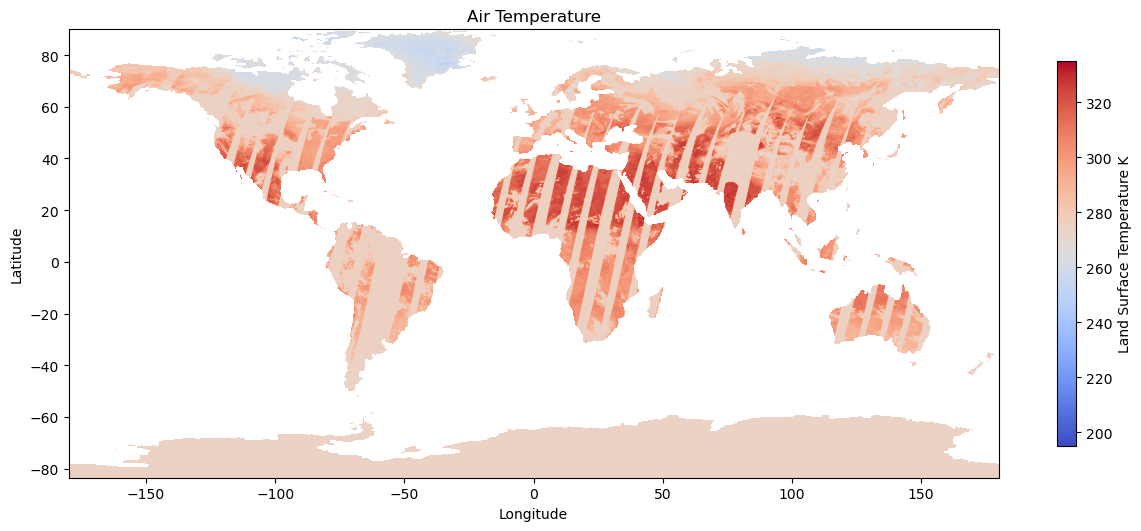

In [22]:
from ml4xcube.xr_plots import plot_slice

df  = pd.concat([orig["land_surface_temperature"], output["land_surface_temperature"]])
lst = df.reset_index()

# Reverse latitude values & reset index
lst["lat"] = -lst["lat"] 
lst       = lst.set_index(["lat", "lon"])

ds_updated = lst.to_xarray()

plot_slice(
    ds          = ds_updated,
    var_to_plot = "land_surface_temperature",
    xdim        = "lon",
    ydim        = "lat",
    color_map   = "coolwarm",
    title       = "Air Temperature",
    label       = "Land Surface Temperature K", 
    vmin        = 195,
    vmax        = 335
)